Re-calculate bimodal parameters for each CCN_observation window. (We want to used NSD1_sum and NSD2_sum for each window)

In [1]:
import numpy as np
import os
import pandas as pd


In [2]:
# load data:
obs_dir = '../input_data'   

bimodal_params = pd.read_csv(os.path.join(obs_dir, 'Bimodal_parameters.csv'))  # Fitted bimodal parameters, which we are recalculating because it does not contain scaled number concentration values.
NSD_params_all = pd.read_csv(os.path.join(obs_dir, 'NSD_PARAMS_SCALED.CSV'), parse_dates=['datetime'])  # bimodal parameters scaled to aerosol observations at 10min resolution
CCN_all = pd.read_csv(os.path.join(obs_dir, 'CCN_all.csv'), parse_dates=['datetime','start_time','end_time'])  # observed CCN data (contains CCN-obs Window information (start and end time), 2hr resolution)

In [3]:
# function to calculate the median absolute deviation (MAD):

def mad(series):
    mad = np.median(np.abs(series - series.median()))
    return max(mad, 0.01)  # ensure MAD is not zero

In [4]:
# function to calculate the interquartile range (IQR):
def iqr(series):
    q75, q25 = np.percentile(series, [75, 25])
    return max(q75 - q25, 0.01)  # ensure IQR is not zero

In [20]:
#re-calculate median bimodal parameters for each 2 hr window, with scaled number concentration:

NSD_params = NSD_params_all.copy(deep=True)

tw_start = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['start_time'] # time window start
tw_end = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['end_time'] # time window end
tw_mid = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['datetime'] # time window mid
window_idx = 0

# create mask which identifies which time window parameters belong to:
for i in range(len(tw_start)):
    mask = (
        (NSD_params['datetime'] >= tw_start[i]) &
        (NSD_params['datetime'] < tw_end[i])         
    )
    
    if mask.any():
        NSD_params.loc[mask, 'CCN_window'] = window_idx # index of the time window, used for grouping
        NSD_params.loc[mask, 'datetime'] = tw_mid[i] # assign the mid-point of the time window to the datetime column
        window_idx += 1

# drop rows with NaN in CCN_window column (no data in that time window):
NSD_params = NSD_params.dropna(subset=['CCN_window'])

# drop where the datetime does not match original datetimes in bimodal_params:
NSD_params = NSD_params[NSD_params['datetime'].isin(pd.to_datetime(bimodal_params['datetime']))].reset_index(drop=True)

# THERE IS ONE OBS WINDOW WHERE THE NSD PARAMETERS ARE VERY STRANGE AND RESULT IN UNREALISTIC MASS VALUES:
# here we filter these out:
NSD_params = NSD_params[~((NSD_params['CCN_window'] == 8564.0) & (NSD_params['mode2_d']>100))]

# Take median of parameters within each time window:
NSD_params_medians = NSD_params.groupby('CCN_window').median().copy(deep=True).reset_index(drop=True) # take median of parameters within each time window
NSD_params_mads = NSD_params.groupby('CCN_window').apply(lambda x: x.select_dtypes(include='number').agg(mad), include_groups=False).copy(deep=True).reset_index(drop=True)  # take median absolute deviation of parameters within each time window
NSD_params_mads = NSD_params_mads.rename(columns=lambda x: x + '_mad')  # rename columns to indicate MAD

# Calculated interquartile range (IQR) for each parameter:
NSD_params_iqr = NSD_params.groupby('CCN_window').apply(lambda x: x.select_dtypes(include='number').agg(iqr), include_groups=False).copy(deep=True).reset_index(drop=True)  # take IQR of parameters within each time window
NSD_params_iqr = NSD_params_iqr.rename(columns=lambda x: x + '_iqr')  # rename columns to indicate IQR

# additional dfs for max/min  in each time window:
NSD_params_maxs = NSD_params.groupby('CCN_window').max().copy(deep=True).reset_index(drop=True)
NSD_params_maxs = NSD_params_maxs.rename(columns=lambda x: x + '_max')  # rename columns to indicate max
NSD_params_mins = NSD_params.groupby('CCN_window').min().copy(deep=True).reset_index(drop=True)
NSD_params_mins = NSD_params_mins.rename(columns=lambda x: x + '_min')  # rename columns to indicate min

# merge median and MAD dataframes:
NSD_params_windows = pd.concat([NSD_params_medians, NSD_params_mads, NSD_params_iqr, NSD_params_maxs, NSD_params_mins], axis=1)

# add column for number of measurements in each time window:
NSD_params_windows['n_measurements'] = NSD_params.groupby('CCN_window')['mode1_d'].count().reset_index(drop=True)


# create a unique ID for each time window for original dataset:
NSD_params['window_id'] = pd.factorize(NSD_params['CCN_window'])[0]  
NSD_params_windows['window_id'] = pd.unique(NSD_params['window_id'])

# reorder columns:
col_order = ['datetime','mode1_d', 'mode1_d_mad', 'mode1_d_iqr', 'mode1_d_max', 'mode1_d_min', 'mode1_sigma', 
             'NSD1_sum', 'NSD1_sum_mad', 'NSD1_sum_iqr', 'NSD1_sum_max', 'NSD1_sum_min',
             'mode2_d', 'mode2_d_mad', 'mode2_d_iqr', 'mode2_d_max', 'mode2_d_min', 'mode2_sigma', 
             'NSD2_sum', 'NSD2_sum_mad', 'NSD2_sum_iqr', 'NSD2_sum_max', 'NSD2_sum_min',
             'n_measurements', 'window_id']

NSD_params_windows = NSD_params_windows[col_order]

In [21]:
# save to CSV:
NSD_params_windows.to_csv(os.path.join(obs_dir, 'bimodal_params_windows_iqr.csv')) 
NSD_params.to_csv(os.path.join(obs_dir, 'NSD_params_withwindows.csv'))  

Text(0, 0.5, '0.5*IQR of mode1_d')

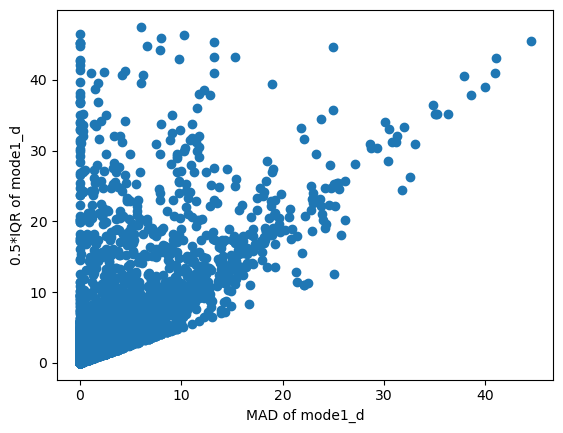

In [12]:
import matplotlib.pyplot as plt
plt.scatter(NSD_params_windows['mode1_d_mad'], NSD_params_windows['mode1_d_iqr']*0.5)
plt.xlabel('MAD of mode1_d')
plt.ylabel('0.5*IQR of mode1_d')

Text(0, 0.5, '0.5*IQR of NSD1_sum')

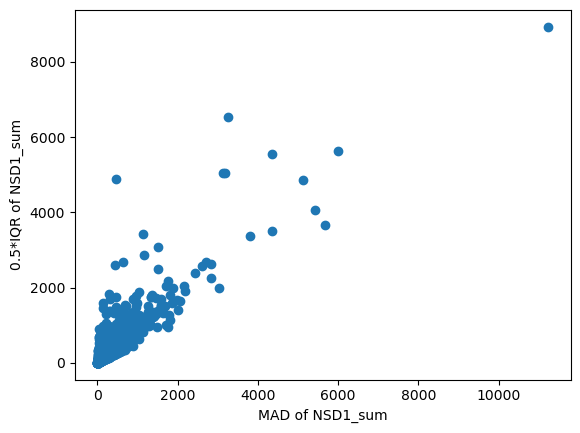

In [13]:
plt.scatter(NSD_params_windows['NSD1_sum_mad'], NSD_params_windows['NSD1_sum_iqr']*0.5)
plt.xlabel('MAD of NSD1_sum')
plt.ylabel('0.5*IQR of NSD1_sum')

In [6]:
NSD_params.loc[NSD_params['window_id'] == 84.0]

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum,CCN_window,window_id
734,2016-08-24 05:00:00,100.0,1.75,1065.345215,293.952702,1.75,79.270875,1050.880353,68.288683,84.0,84
735,2016-08-24 05:00:00,75.0,1.75,131.857774,105.106872,1.75,988.795147,123.275173,999.687424,84.0,84
736,2016-08-24 05:00:00,75.0,1.75,141.877198,105.106872,1.75,968.780859,131.327754,983.530267,84.0,84
737,2016-08-24 05:00:00,75.0,1.75,103.465044,105.106872,1.75,1003.314086,95.229230,1008.993478,84.0,84
738,2016-08-24 05:00:00,100.0,1.75,1055.713590,336.788876,1.75,83.108953,1032.784682,66.996895,84.0,84
739,2016-08-24 05:00:00,75.0,1.75,97.025723,105.106872,1.75,975.482765,90.805221,986.139348,84.0,84
740,2016-08-24 05:00:00,75.0,1.75,114.852217,105.106872,1.75,941.890509,104.297337,944.883509,84.0,84
741,2016-08-24 05:00:00,75.0,1.75,58.698648,105.106872,1.75,956.760097,54.998446,965.406594,84.0,84
742,2016-08-24 05:00:00,100.0,1.75,952.084660,293.952702,1.75,87.009145,916.797335,76.044037,84.0,84


In [20]:
NSD_params_all.loc[NSD_params_all['datetime'] == '2016-08-25 19:00:00']

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum


In [7]:
NSD_params_windows.loc[84]

datetime           2016-08-24 05:00:00
mode1_d                           75.0
mode1_sigma                       1.75
mode1_n                     131.857774
mode2_d                     105.106872
mode2_sigma                       1.75
mode2_n                     956.760097
NSD1_sum                    123.275173
NSD2_sum                    965.406594
mode1_d_mad                       0.01
mode1_sigma_mad                   0.01
mode1_n_mad                  34.832051
mode2_d_mad                       0.01
mode2_sigma_mad                   0.01
mode2_n_mad                   32.03505
NSD1_sum_mad                 32.469952
NSD2_sum_mad                 34.280829
mode1_d_iqr                       25.0
mode1_sigma_iqr                   0.01
mode1_n_iqr                 848.619615
mode2_d_iqr                  188.84583
mode2_sigma_iqr                   0.01
mode2_n_iqr                  888.47362
NSD1_sum_iqr                821.568105
NSD2_sum_iqr                 910.09531
n_measurements           